## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-discoveryengine google-cloud-aiplatform japanize_matplotlib

In [2]:
# カーネル再起動
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## ファイル検索処理実行

In [1]:
from google.cloud import discoveryengine_v1alpha as discoveryengine
from google.api_core.client_options import ClientOptions

[PROJECT_ID] = !gcloud config list --format 'value(core.project)'
DATASTORE_ID = 'movie-search-datastore_xxxxxxxx' # 実際のデータストア ID を入力
LOCATION = 'global'

In [4]:
def get_documents(query, show_summary=True):
    client = discoveryengine.SearchServiceClient(
        client_options=ClientOptions(api_endpoint=f'{LOCATION}-discoveryengine.googleapis.com'),
    )
    request = discoveryengine.SearchRequest(
        serving_config=client.serving_config_path(
            project=PROJECT_ID,
            location=LOCATION,
            data_store=DATASTORE_ID,
            serving_config='default_search:search',
        ),
        content_search_spec = discoveryengine.SearchRequest.ContentSearchSpec(
            search_result_mode='DOCUMENTS',
            summary_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec(
                summary_result_count=3,
                include_citations=True,
                model_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec.ModelSpec(
                    version='stable'
                )
            ),
        ),
        query=query,
    )
    response = client.search(request)
    if show_summary:
        print(response.summary.summary_text)
    for c, item in enumerate(response.results):
        print(f'[{c+1}]: {item.document.derived_struct_data["link"]}')
    return response

In [5]:
response = get_documents('ニューラルスケーリング則を解説するシーン')

ニューラルスケーリング則は、ニューラルネットワークのサイズが大きくなればなるほど性能が向上するという法則です [1]。この法則は、2012年にGoogleのJeff Dean氏が発表したディープラーニングに関する研究成果に基づいています [1]。この研究成果により、大規模言語モデルを支える分散学習インフラPathwaysのアイデアが生まれました [1]。Pathwaysは、マルチモーダル、マルチタスクなモデルの学習に利用できることが期待されています [1]。Pathwaysは、Googleが開発したTPUを用いた分散学習システムによって実現されています [1]。 

[1]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[2]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
[3]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt


In [6]:
response = get_documents('デモブースを体験するシーン')

Google Cloud Next Tokyo '24 のイノベーターズハイブエリアでは、エンジニアやデベロッパー向けに様々な情報や体験を提供しています [1]。ブースでは、ミニカーのレースデータを取得・分析する BigQuery Racing Insights や、パターゴルフをプレイしながら AI による実況解説を体験できる Mini Golf with Gemini などがあります [1]。また、ゲームのようにボタンを叩き負荷分散を体験できる Beat Google at Load Balancing や、サーバーレスで動く列車を体験しながらクラウドの仕組みを楽しく学べる Cloud Express Architect のブースもあります [1]。さらに、手書きのワイヤーフレームから生成AIを使ってWeb開発の効率をどのように高められるかを紹介する Instant Web with Gemini のブースもあります [1]。これらのブースでは、Google Cloud の技術やサービスを実際に体験することができます。 

[1]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt
[2]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[3]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt


In [7]:
response = get_documents('データセンターのセキュリティを説明するシーン')

Googleのデータセンターは、6層のセキュリティ対策を導入しており、サーマルスキャナー、金属探知機、クレデンシャルバッジと生体認証データによる二要素認証などがあります [1]。これは、すべてのユーザーとGoogle Cloudのお客様のために、データセンターを安全に保護するためです [1]。データセンターでは、重要なインフラの運用・維持を24時間365日行っています [1]。高いパフォーマンスを維持するために、電力や冷却システムの継続的な供給が必要不可欠であり、地域の環境や気候に沿ったGoogle基準のメンテナンスを実施することで、世界のGoogleデータセンターと同レベルの信頼性を実現しています [1]。また、インフラを効率的に運用していることも特徴の一つであり、一般的な企業のデータセンターと比較して約2倍のエネルギー効率を誇ります [1]。 

[1]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
[2]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[3]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt


## シーン検索との連携

In [8]:
import re, os, shutil, copy, json, datetime, pprint
import numpy as np
import pandas
from pandas import DataFrame
from collections import Counter

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [9]:
BUCKET = f'gs://{PROJECT_ID}-sample'
[PROJECT_ID] = !gcloud config get-value project
vertexai.init(project=PROJECT_ID, location='us-central1')

model_flash = GenerativeModel('gemini-1.5-flash')

In [ ]:
# 静止画像ファイルをローカルにコピー
target_list = [
    f'{BUCKET}/mp4/s_千葉県印西市にデータセンターを開設.mp4',
    f'{BUCKET}/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4',
    f'{BUCKET}/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4',
]

for target in target_list:
    filename = target.split('/')[-1]
    basename = filename.rstrip('.mp4').lstrip('s_')
    image_dir = f'{BUCKET}/image/{basename}'
    gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
    local_image_dir = basename
    !gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

In [13]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

def show_thumbnails(scenes, local_image_dir):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(2, 5, figsize=(15, 4))  # Adjust figsize as needed
        axs = axs.ravel()
        print('-----')
        print(str(item['Description']))
        #fig.suptitle(str(item['Description']), fontsize=12)
        for c, ts in enumerate(np.linspace(max(1, ss1-5), min(ss2+5, m), 10)):
            ts = int(ts)
            mm, ss = divmod(ts, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [14]:
def generate(prompt, model, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [15]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}


[user query]
{query}

{metatext}
'''

In [19]:
def scene_search(query, top_n=1, model=model_flash):
    response = get_documents(query, show_summary=False)
    for doc_id in range(min(top_n, len(response.results))):
        meta_uri = response.results[doc_id].document.derived_struct_data['link']
        local_image_dir = meta_uri.split('/')[-1].rstrip('.txt')
        !gsutil cp "{meta_uri}" metadata.txt
        with open('metadata.txt', 'r') as f:
            metatext = f.read()
        prompt = prompt_content_search.format(query=query, metatext=metatext)
        temperature = 0.4
        result = None
        while temperature < 1.0:
            try:
                result = generate(prompt, model=model, temperature=temperature)
                result = load_json(result)
                break
            except Exception as e:
                print(e)
                temperature += 0.05
        if temperature < 1.0:
            print('\n=====')
            print(f'動画名：{local_image_dir}')
            show_thumbnails(result, local_image_dir)

[1]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[2]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
[3]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt
Copying gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt...
/ [1 files][ 81.3 KiB/ 81.3 KiB]                                                
Operation completed over 1 objects/81.3 KiB.                                     
```json
[
  {
    "Timestamp": "04:57-05:58",
    "Description": "このシーンでは、中井 悦司氏が、モデルのサイズが大きいほど性能が向上するニューラルスケーリングローという名前があること、それを実証する事例として、2020年に発表されたGPT-3という自然言語モデルと、2021年にGoogleが発表したGLaMモデルを紹介しています。ニューラルスケーリング則の説明に該当します。"
  }
]
```
=====
動画名：大規模言語モデルを支える分散学習インフラ Pathways
-----
このシーンでは、中井 悦司氏が、モデルのサイズが大きいほど性能が向上するニューラルスケーリングローという名前があること、それを実証する事例として、2020年に発表されたGPT-3という自然言語モデルと、2021年にGoogleが発表したGLaMモデルを紹介しています。ニューラルスケーリング則の説明に該当します。


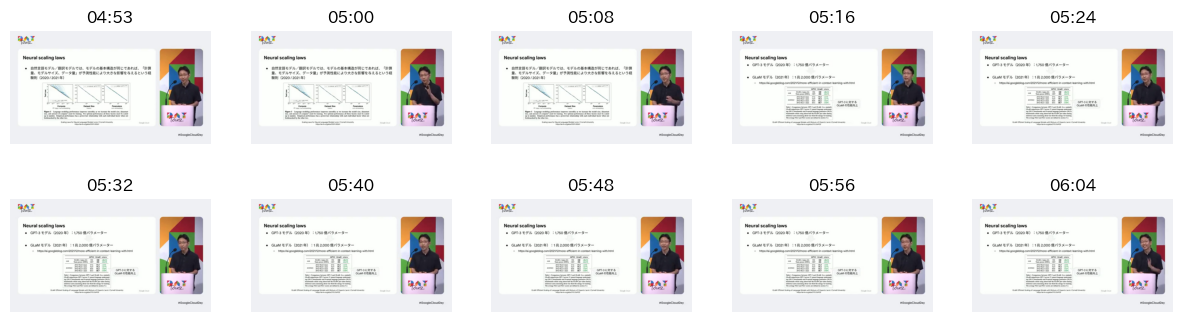

<Figure size 640x480 with 0 Axes>

In [20]:
response = scene_search('ニューラルスケーリング則を解説するシーン')

[1]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt
[2]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
[3]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
Copying gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt...
/ [1 files][ 42.6 KiB/ 42.6 KiB]                                                
Operation completed over 1 objects/42.6 KiB.                                     
```json
[
  {
    "Timestamp": "01:29-01:41",
    "Description": "佐々木 茜さんがイノベーターズハイブについて説明しているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。"
  },
  {
    "Timestamp": "01:41-02:09",
    "Description": "佐々木 茜さんが Innovators Stage と Ask the Expert について説明しているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。"
  },
  {
    "Timestamp": "02:09-02:37",
    "Description": "佐々木 茜さんがクイズチャレンジについて説明しているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。"
  },
  {
    "Timestamp": "03:24-03:44",
    "Description": "河野 豪さんと小栗 香菜恵

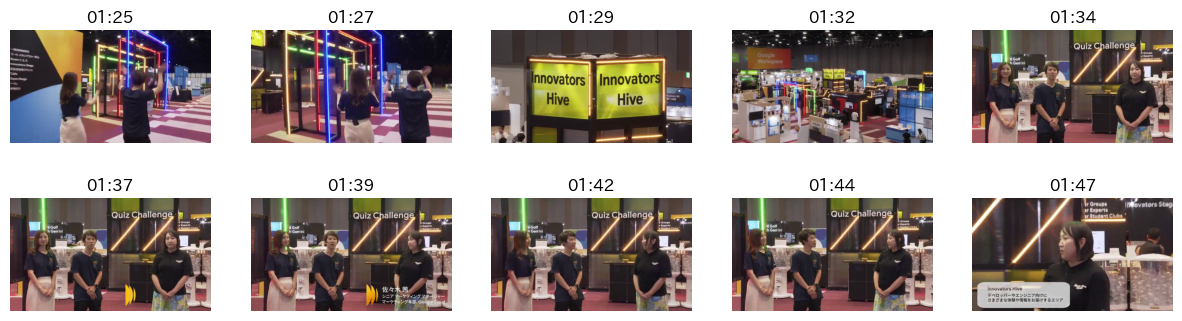

-----
佐々木 茜さんが Innovators Stage と Ask the Expert について説明しているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。


<Figure size 640x480 with 0 Axes>

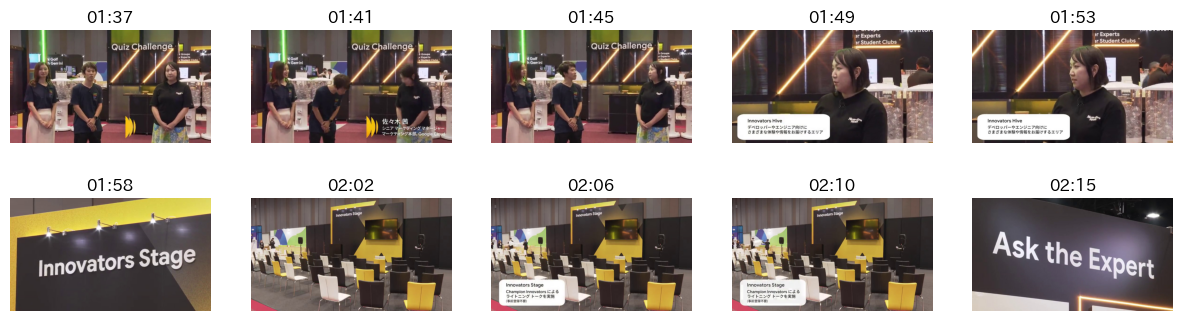

-----
佐々木 茜さんがクイズチャレンジについて説明しているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。


<Figure size 640x480 with 0 Axes>

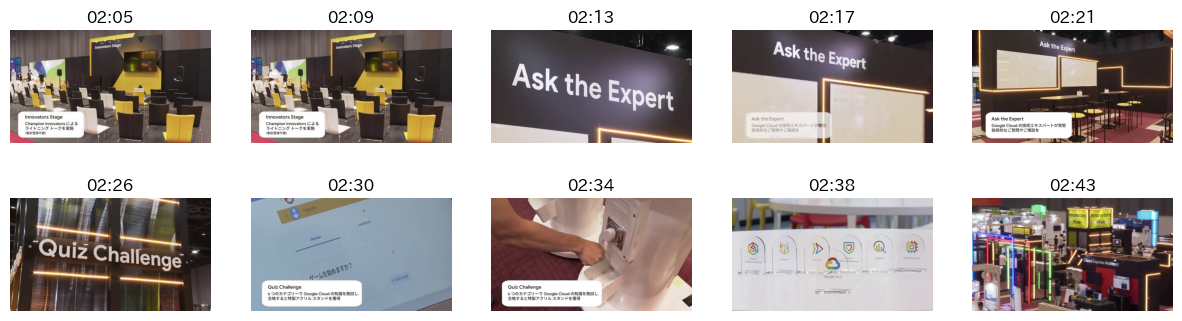

-----
河野 豪さんと小栗 香菜恵さんが佐々木 茜さんに話を聞いているシーンです。佐々木 茜さんは画面中央に映っており、アップで写っています。


<Figure size 640x480 with 0 Axes>

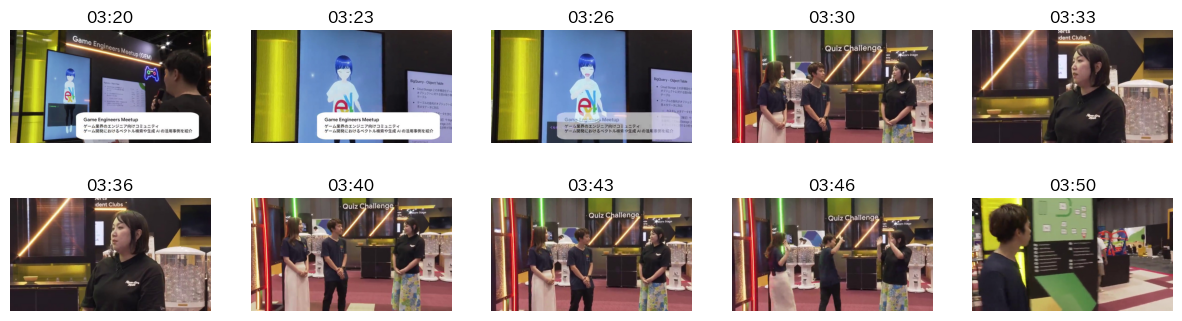

<Figure size 640x480 with 0 Axes>

In [22]:
response = scene_search('佐々木さんがアップで写っているシーン')

[1]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
[2]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[3]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt
Copying gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt...
/ [1 files][ 20.7 KiB/ 20.7 KiB]                                                
Operation completed over 1 objects/20.7 KiB.                                     
```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "このシーンでは、金井匡彦氏がデータセンター建設責任者として紹介され、2023年に千葉県印西市にデータセンターを開設したことを発表しています。"
  }
]
```
=====
動画名：千葉県印西市にデータセンターを開設
-----
このシーンでは、金井匡彦氏がデータセンター建設責任者として紹介され、2023年に千葉県印西市にデータセンターを開設したことを発表しています。


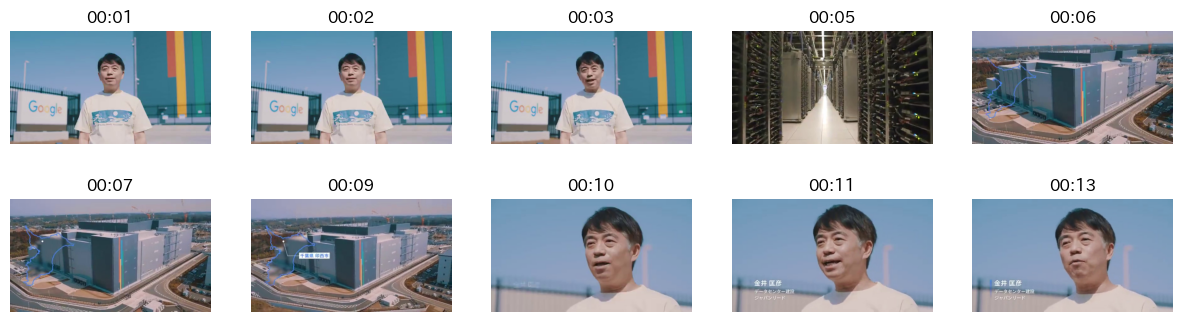

<Figure size 640x480 with 0 Axes>

In [23]:
response = scene_search('データセンター建設責任者の登場シーン')

[1]: gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt
[2]: gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt
[3]: gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt
Copying gs://your-project-handson/metadata/大規模言語モデルを支える分散学習インフラ Pathways.txt...
/ [1 files][ 81.3 KiB/ 81.3 KiB]                                                
Operation completed over 1 objects/81.3 KiB.                                     
```json
[
  {
    "Timestamp": "00:00-00:12",
    "Description": "このシーンでは、イベントのタイトルと発表者の名前、所属が表示されます。視覚的にインパクトがあり、SNS投稿に適しています。"
  },
  {
    "Timestamp": "06:14-07:22",
    "Description": "このシーンでは、自然言語で文章を入力すると、その文章にマッチした画像を生成する画像生成モデルが紹介されています。画像生成モデルは、視覚的に魅力的なコンテンツであり、SNS投稿に適しています。"
  },
  {
    "Timestamp": "07:24-08:13",
    "Description": "このシーンでは、テキスト文や動画で命令を入力すると、ロボットアームがその通りに動いてくれるというモデルが紹介されています。ロボットアームが動く様子は、視覚的にインパクトがあり、SNS投稿に適しています。"
  }
]
```
=====
動画名：大規模言語モデルを支える分散学習インフラ Pathways
-----
このシーン

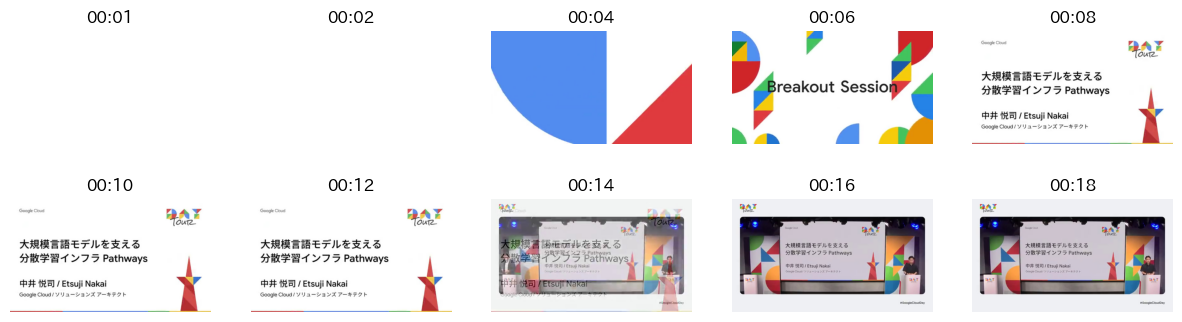

-----
このシーンでは、自然言語で文章を入力すると、その文章にマッチした画像を生成する画像生成モデルが紹介されています。画像生成モデルは、視覚的に魅力的なコンテンツであり、SNS投稿に適しています。


<Figure size 640x480 with 0 Axes>

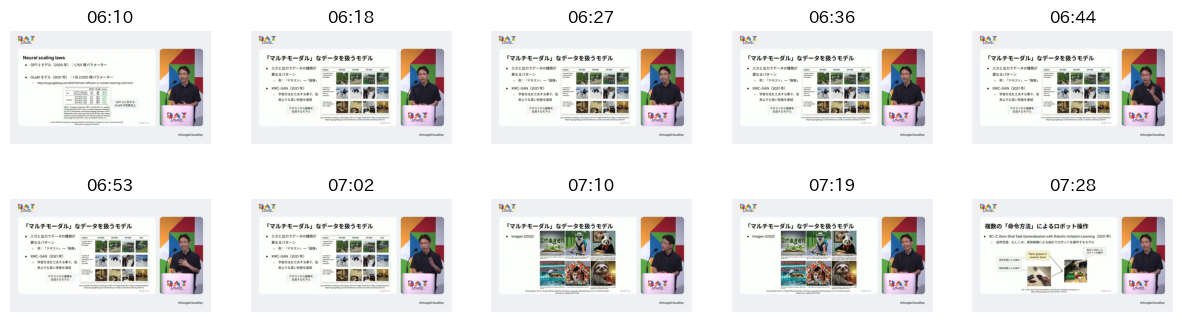

-----
このシーンでは、テキスト文や動画で命令を入力すると、ロボットアームがその通りに動いてくれるというモデルが紹介されています。ロボットアームが動く様子は、視覚的にインパクトがあり、SNS投稿に適しています。


<Figure size 640x480 with 0 Axes>

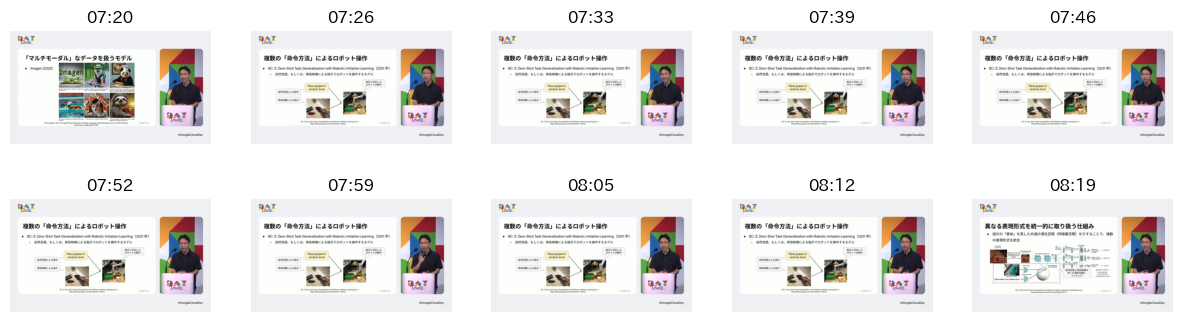

Copying gs://your-project-handson/metadata/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.txt...
/ [1 files][ 42.6 KiB/ 42.6 KiB]                                                
Operation completed over 1 objects/42.6 KiB.                                     
```json
[
  {
    "Timestamp": "00:05-00:30",
    "Description": "イベント会場の準備風景が映し出され、華やかな雰囲気とイベントへの期待感を高める映像は、SNS投稿に視覚的なインパクトを与えます。"
  },
  {
    "Timestamp": "06:22-08:34",
    "Description": "小栗 香菜恵さんが Mini Golf with Gemini のブースでパターゴルフに挑戦するシーンは、ユニークで印象的な映像であり、SNS投稿に適しています。"
  },
  {
    "Timestamp": "08:35-09:20",
    "Description": "インタラクティブデモエリアの様子は、参加者がゲームのように楽しんでいる様子が伝わり、見ている人に楽しさを共有できる映像です。"
  }
]
```
=====
動画名：Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -
-----
イベント会場の準備風景が映し出され、華やかな雰囲気とイベントへの期待感を高める映像は、SNS投稿に視覚的なインパクトを与えます。


<Figure size 640x480 with 0 Axes>

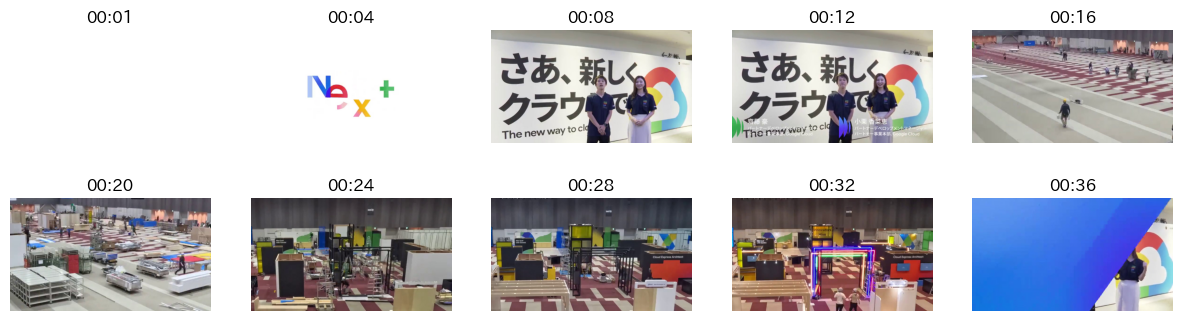

-----
小栗 香菜恵さんが Mini Golf with Gemini のブースでパターゴルフに挑戦するシーンは、ユニークで印象的な映像であり、SNS投稿に適しています。


<Figure size 640x480 with 0 Axes>

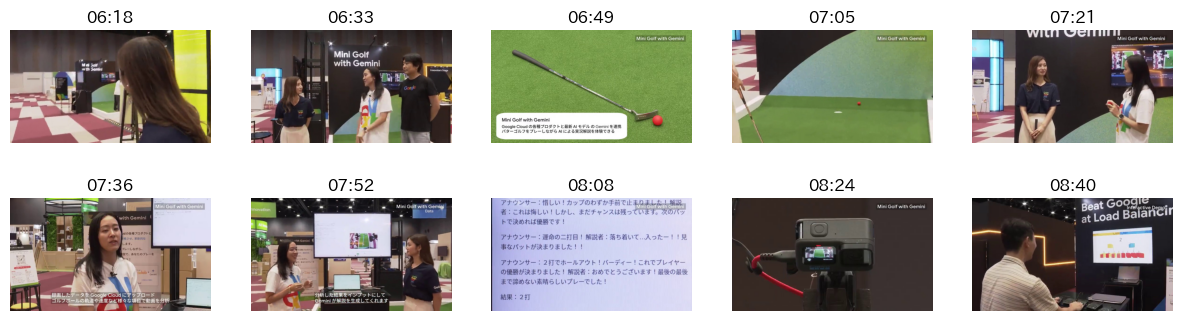

-----
インタラクティブデモエリアの様子は、参加者がゲームのように楽しんでいる様子が伝わり、見ている人に楽しさを共有できる映像です。


<Figure size 640x480 with 0 Axes>

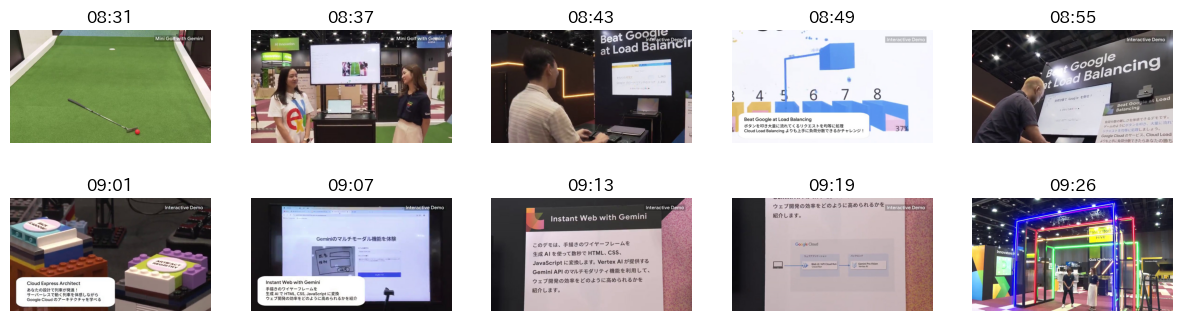

Copying gs://your-project-handson/metadata/千葉県印西市にデータセンターを開設.txt...
/ [1 files][ 20.7 KiB/ 20.7 KiB]                                                
Operation completed over 1 objects/20.7 KiB.                                     
```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "Google の看板の前で金井 匡彦さんがデータセンター開設を発表しているシーン。インパクトのある映像と、Google のロゴが映し出されることで、SNS 投稿に適しています。"
  },
  {
    "Timestamp": "00:03-00:06",
    "Description": "千葉県印西市に建設された Google データセンターの外観。グレーの壁に Google のロゴカラーである赤、黄、緑、青のラインが入ったデザインは、視覚的にインパクトがあり、SNS 投稿に適しています。"
  },
  {
    "Timestamp": "00:44-00:48",
    "Description": "データセンター内部のサーバーラック。緑色の LED が点灯しているサーバーが多数設置されており、通路の奥は暗く、サーバーラックの LED だけが明るく光っている様子は、幻想的でインパクトのある映像です。"
  }
]
```
=====
動画名：千葉県印西市にデータセンターを開設
-----
Google の看板の前で金井 匡彦さんがデータセンター開設を発表しているシーン。インパクトのある映像と、Google のロゴが映し出されることで、SNS 投稿に適しています。


<Figure size 640x480 with 0 Axes>

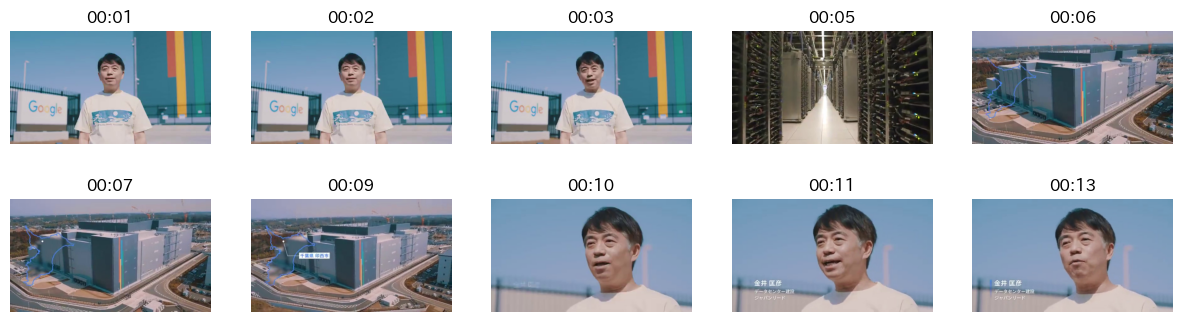

-----
千葉県印西市に建設された Google データセンターの外観。グレーの壁に Google のロゴカラーである赤、黄、緑、青のラインが入ったデザインは、視覚的にインパクトがあり、SNS 投稿に適しています。


<Figure size 640x480 with 0 Axes>

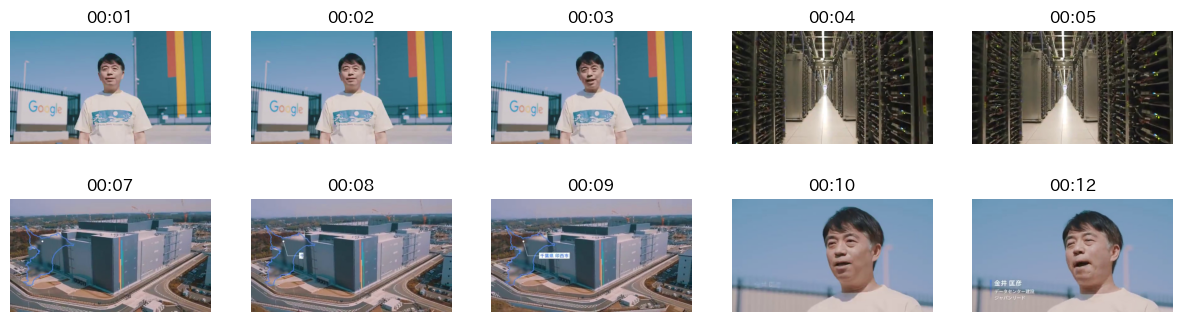

-----
データセンター内部のサーバーラック。緑色の LED が点灯しているサーバーが多数設置されており、通路の奥は暗く、サーバーラックの LED だけが明るく光っている様子は、幻想的でインパクトのある映像です。


<Figure size 640x480 with 0 Axes>

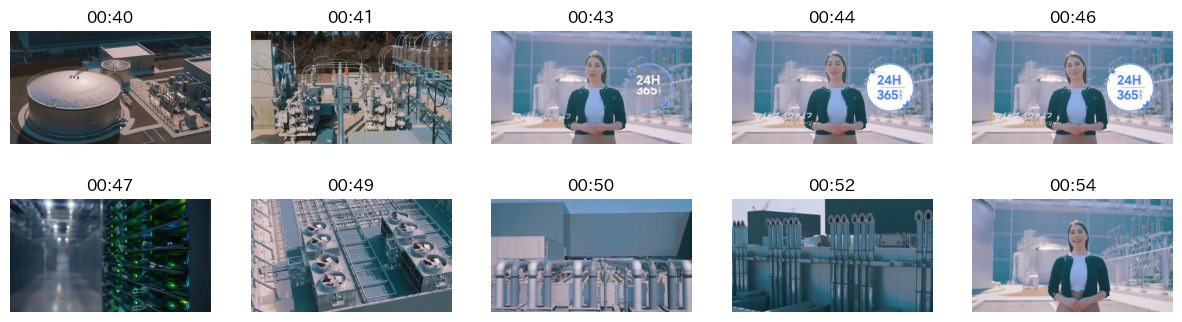

<Figure size 640x480 with 0 Axes>

In [27]:
response = scene_search('見た目にインパクトがあるSNS投稿に適した魅力的なシーン', top_n=3)